In [1]:
from ssrq_retro_lab.config import PROJECT_ROOT
from ssrq_retro_lab.repository import reader

In [2]:
training_path = (PROJECT_ROOT / "data/ZG")
validation_files =["openai_classification_validation.jsonl", "openai_ocr_validation.jsonl", "openai_splitting_validation.jsonl"]

In [8]:
from ssrq_retro_lab.train import train

model_id = train.get_finetuned_model_id("ftjob-aRl2LY061gfRiEowCpHNyphM")

In [42]:
import openai

def filter_assistant_from_message(messages: dict[str, list[dict[str, str]]]) -> list[dict[str, str]]:
    return [item for item in messages['messages'] if item['role'] != 'assistant']

def model_completion(model_id: str, messages: dict[str, list[dict[str, str]]]):
    res = openai.chat.completions.create(
        model=model_id,
        messages=filter_assistant_from_message(messages=messages), # type: ignore
        temperature=0,
        max_tokens=4096,
        seed=5
    )
    return res

def extract_text_from_completion(completion: str, split_index: int = 1) -> str:
    if "```" in completion:
        return completion.split("```")[split_index]

    raise ValueError("Completion does not contain ``` – cannot extract text")


In [35]:
ocr_validation_data = reader.JSONLReader((training_path / validation_files[1])).read()

preditions: list[str] = []
actuals: list[str] = []

for item in ocr_validation_data:
    expected_text = extract_text_from_completion([x for x in item['messages'] if x['role'] == 'assistant'][0]['content'])
    preditions.append(expected_text)
    actual_completion = model_completion(model_id=model_id, messages=item)
    actual_text = actual_completion.choices[0].message.content
    assert actual_text is not None
    actuals.append(extract_text_from_completion(actual_text))


The following cells will validate the quality finetuned model. We will use the same metrics as in the previous notebook (see [extract pdf text](./extract_pdf_text.ipynb)) as well a some additional metrics typically used in machine learning.

The metrics are:
- **CER**: Character Error Rate (lower is better)
- **Cosine Similarity**: Cosine similarity between the vectorized text and the vectorized ground truth (higher is better)
- **Accuracy**: Accuracy of the model; calculated by the following formula: (Total number of correct predictions) / (Total number of predictions) --> (higher is better)
- **F-Score**: F-Score of the model – which means the harmonic mean of precision and recall; calculated by the following formula: 2 * (precision * recall) / (precision + recall) --> (higher is better)

In [60]:
from ssrq_retro_lab.validate import ocr as ocr_validation
from collections import namedtuple

OCRValidation = namedtuple(
    "OCRValidation",
    ["input_text", "expected_text", "output_text", "cer", "cosine_similarity"],
)

ocr_validation_results: list[OCRValidation] = []

for index, pairs in enumerate(zip(preditions, actuals)):
    input_text = extract_text_from_completion(
        [x for x in ocr_validation_data[index]["messages"] if x["role"] == "user"][0][
            "content"
        ],
        2,
    )
    ocr_quality =ocr_validation.calc_error_rate(pairs[0], pairs[1])
    ocr_validation_results.append(OCRValidation(input_text, pairs[0], pairs[1], *ocr_quality))


In [61]:
import pandas as pd

ocr_validation_df = pd.DataFrame(ocr_validation_results)

In [47]:
ocr_validation_df

,input_text,expected_text,output_text,cer,cosine_similarity
0,\nE. Staatswesen • 572-583\n377\nStAZürich A 2...,\nE. Staatswesen : 572-183 377\nStAZürich A 25...,\nE. Staatswesen · 572-583 377\nStAZürich A 25...,0.866021,0.993117
1,\nD. Die Stadt- und Amtbücher • 462-464\n345\n...,\nD. Die Stadt- und Amtbücher · 462–464 345\na...,\nD. Die Stadt- und Amtbücher · 462–464 345\na...,0.252525,0.999538
2,\nA. Die geistlichen Grundherrschaften im Mitt...,\nA. Die geistlichen Grundherrschaften im Mitt...,\nA. Die geistlichen Grundherrschaften im Mitt...,1.454177,0.985244
3,\n882 \nIII. Stadt Zug und ihre Vogteien\nwere...,\n882 III. Stadt Zug und ihre Vogteien\nwere u...,\n882 III. Stadt Zug und ihre Vogteien\nwere u...,0.846660,0.991894
4,\n976 \nIV. Die drei Gemeinden des äußeren Amt...,\n976 IV. Die drei Gemeinden des äußeren Amtes...,\n976 IV. Die drei Gemeinden des äußeren Amtes...,0.599908,0.995396
5,\nB. Die städtischen Vogteien • 1587-1589\n877...,\nB. Die städtischen Vogteien · 1587–1589 877\...,\nB. Die städtischen Vogteien · 1587–1589 877\...,0.188235,0.997863


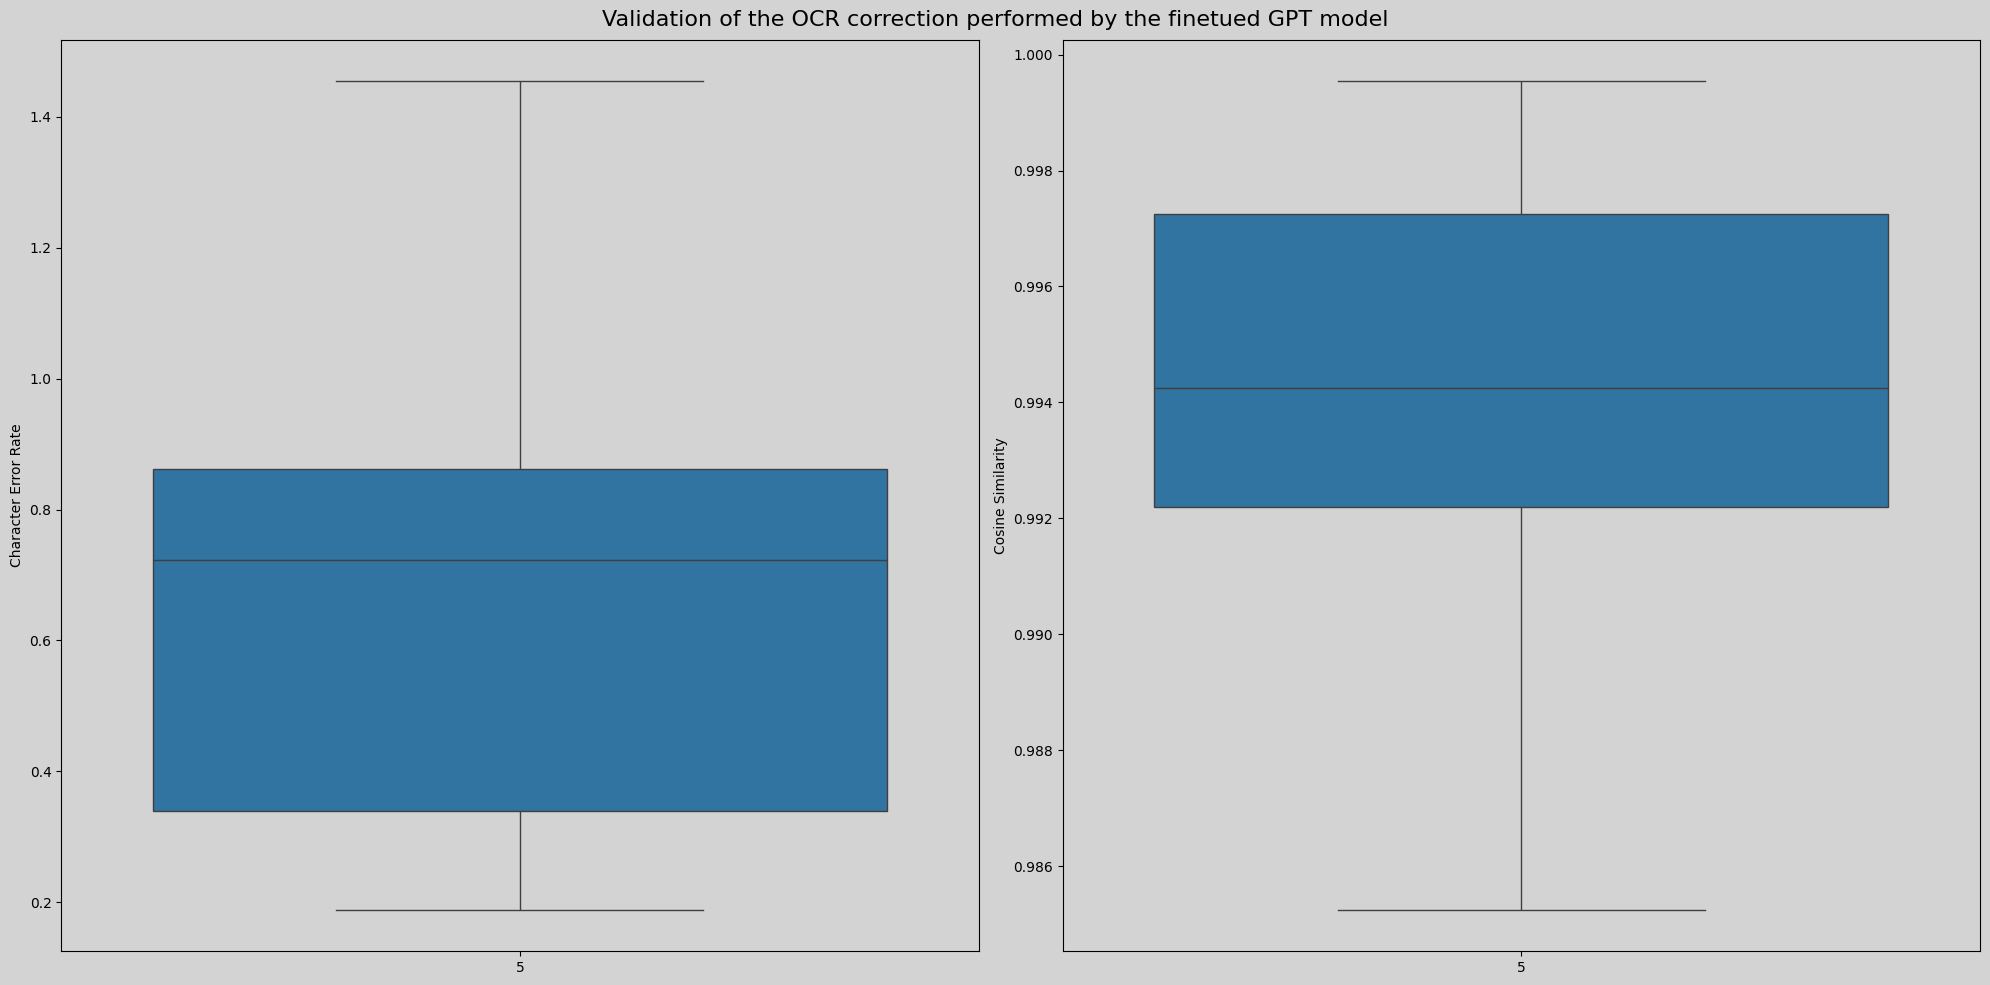

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
fig.set_facecolor('lightgray')
plot_one = sns.boxplot(x=index, y='cer', data=ocr_validation_df, ax=ax[0])
plot_one.set_ylabel('Character Error Rate')
plot_one.set_facecolor('lightgray')

plot_two = sns.boxplot(x=index, y='cosine_similarity', data=ocr_validation_df, ax=ax[1])
plot_two.set_ylabel('Cosine Similarity')
plot_two.set_facecolor('lightgray')

fig.suptitle('Validation of the OCR correction performed by the finetued GPT model', fontsize=16)

plt.tight_layout()
plt.show()

In [62]:
print(f"The average CER is {ocr_validation_df['cer'].mean()}")
print(f"The average cosine similarity is {ocr_validation_df['cosine_similarity'].mean()}")

The average CER is 0.7012544290579431
The average cosine similarity is 0.9938420018986515


In [72]:
import re

def extract_start_marker(text: str) -> list[str]:
    return re.findall(r'\[START\]', text)

splitting_validation_data = reader.JSONLReader((training_path / validation_files[2])).read()

expected_splitted_texts: list[str] = []
expected_starts: list[str] = []
actual_splitted_texts: list[str] = []
actual_starts: list[str] = []

for item in splitting_validation_data:
    expected_text = [x for x in item['messages'] if x['role'] == 'assistant'][0]['content']
    expected_splitted_texts.append(expected_text)
    expected_starts.extend(extract_start_marker(expected_text))
    actual_completion = model_completion(model_id=model_id, messages=item)
    actual_text = actual_completion.choices[0].message.content
    assert actual_text is not None
    actual_splitted_texts.append(actual_text)
    actual_starts.extend(extract_start_marker(actual_text))


In [75]:
from ssrq_retro_lab.validate import general as general_validation

splitting_validation_metrics = general_validation.calc_ml_metrics(expected_starts, actual_starts)

print(f"The accuracy of the splitting is {splitting_validation_metrics.accuracy}")
print(f"The F1 score of the splitting is {splitting_validation_metrics.f1_score}")

The accuracy of the splitting is 1.0
The F1 score of the splitting is 1.0


The previous cell just validated the quality of the model on the expected `START`-markers. The following will compare the position of the `START`-markers in the ground truth and the predicted text (the one created by GPT).

In [97]:
def find_all_indices(text: str, pattern: str = "[START]") -> list[int]:
    start = 0
    indices: list[int] = []

    while start < len(text):
        start = text.find(pattern, start)
        if start == -1:
            break
        indices.append(start)
        start += len(pattern)

    return indices


expected_start_indices: list[int] = []
actual_start_indicies: list[int] = []

for pair in zip(expected_splitted_texts, actual_splitted_texts):
    cleaned_expected_text = extract_text_from_completion(pair[0], 1).replace("\n", "").strip()
    cleaned_actual_text = extract_text_from_completion(pair[1], 1).replace("\n", "").strip()
    expected_start_indices.extend(
        find_all_indices(cleaned_expected_text)
    )
    actual_start_indicies.extend(
        find_all_indices(cleaned_actual_text)
    )

splitting_validation_metrics_by_index = general_validation.calc_ml_metrics(expected_start_indices, actual_start_indicies)

print(f"The accuracy of the splitting, measured by index, is {splitting_validation_metrics_by_index.accuracy}")
print(f"The F1 score of the splitting, measured by index, is {splitting_validation_metrics_by_index.f1_score}")


The accuracy of the splitting, measured by index, is 0.14285714285714285
The F1 score of the splitting, measured by index, is 0.14285714285714285


According to the previous calculations the finetuned model seems to perform very bad. The accuracy and F1 score are very low (0,14) for the splitting task. So we will perform some more validation here and compare the actual results line by line. 

In [142]:
pd.set_option("display.max_colwidth", 600)

lines_df = [pd.DataFrame(columns=["expected", "actual", "cer"]) for _ in expected_splitted_texts]


for index, pair in enumerate(zip(expected_splitted_texts, actual_splitted_texts)):
    cleaned_expected_text = extract_text_from_completion(pair[0], 1).strip()
    cleaned_actual_text = extract_text_from_completion(pair[1], 1).strip()

    lines1 = cleaned_expected_text.splitlines()
    lines2 = cleaned_actual_text.splitlines()

    for line_index, line in enumerate(zip(lines1, lines2)):
        metrics = ocr_validation.calc_error_rate(line[0], line[1])
        lines_df[index].loc[line_index] = [line[0], line[1], metrics[0]]

I've we take a close at the CER in a line by line comparison the results are overall much better. Furthermore we can see why we have such a low accuracy and F1 score. While the model is very good at predicting the `START`-markers it seems rather bad in ignoring the headers as formulated in the prompt:

```txt 
Take a deep breath and look at the following corrected text, which was created with OCR. The text consists of different sections. A section represents the transcribed text of a document. This section usually starts with a date line and a title. Analyse the text and divide it into the different sections. Mark the start of a section with [START]. Headers can be ignored. Do not make any other changes and retain the line breaks. Note: There may be fragments from the previous page - also mark them as a section. The text starts and ends with ``` as markers. Here is the text: \n\n ```\n[[text]]\n```
```

The last entry of the validation set is a good example for this. In our comparison we can see a classical off-by-one error.

In [148]:
lines_df[-1].head(10)

,expected,actual,cer
0,[START],[START],0.000000
1,"[8] Item wer einen härdfellig machet, der ist dem vogt undt den",B. Die städtischen Vogteien · 1587–1589 877,79.365079
2,"vieren verfallen neün pfundt undt dem sächer drü pfundt ze bueß,","[8] Item wer einen härdfellig machet, der ist dem vogt undt den",75.000000
3,wann es gekhlagt wirdt.,"vieren verfallen neün pfundt undt dem sächer drü pfundt ze bueß,",84.375000
4,"[9] Item wer auch den anderen bluethruß machet, der ist verfallen",wann es gekhlagt wirdt.,80.000000
5,dem vogt und den vieren ze bueß neün pfundt und dem sächer drü,"[9] Item wer auch den anderen bluethruß machet, der ist verfallen",70.769231
6,"pfundt, so es klagt wirdt.",dem vogt und den vieren ze bueß neün pfundt und dem sächer drü,82.258065
7,"[10] Item welcher gegen dem anderen stahel oder isen wirfft, wirdt","pfundt, so es klagt wirdt.",78.787879
8,"es klagt, so ist er dem vogt und den vieren fünff pfundt ze bueß","[10] Item welcher gegen dem anderen stahel oder isen wirfft, wirdt",80.303030
9,schuldig.,"es klagt, so ist er dem vogt und den vieren fünff pfundt ze bueß",93.750000


In [150]:
def extract_categories(text: str) -> list[str]:
    return re.findall(r"\[(DOCUMENT|SUMMARY|FRAGMENT)\]", text)


classification_validation_data = reader.JSONLReader(
    (training_path / validation_files[0])
).read()

expected_classified_texts: list[str] = []
expected_categories: list[str] = []
actual_classified_texts: list[str] = []
actual_categories: list[str] = []

for item in classification_validation_data:
    expected_text = [x for x in item["messages"] if x["role"] == "assistant"][0][
        "content"
    ]
    expected_classified_texts.append(expected_text)
    expected_categories.extend(
        extract_categories(extract_text_from_completion(expected_text, 1))
    )
    actual_completion = model_completion(model_id=model_id, messages=item)
    actual_text = actual_completion.choices[0].message.content
    assert actual_text is not None
    actual_classified_texts.append(actual_text)
    actual_categories.extend(
        extract_categories(extract_text_from_completion(actual_text, 1))
    )

In [152]:
classification_ml_metrics = general_validation.calc_ml_metrics(expected_categories, actual_categories)

print(f"The accuracy of the classification is {classification_ml_metrics.accuracy}")
print(f"The F1 score of the classification is {classification_ml_metrics.f1_score}")

The accuracy of the classification is 0.2857142857142857
The F1 score of the classification is 0.28293135435992584
